In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from signed_distance import *
from nlp_builder import NLPBuilder
from nlp_solver import SQPSolver
from functools import partial

In [2]:
# problem
num_steps = 10
center_obs = jnp.array([0, 0.1])
r_obs = 0.2

dim_robot = 2
r_robot = 0.1
safe_dist = 0.1

q_init = jnp.array([-1, -1])
q_goal = jnp.array([1, 1])
qu, ql = jnp.full(2, 1.1), jnp.full(2, -1.1)

In [3]:
#util functions
def to_mat(x):
    return x.reshape(-1, dim_robot)
def to_vec(mat):
    return mat.flatten()
def at_timestep(i, x):
    return to_mat(x)[i]
def to_vel(x):
    return (to_mat(x)[1:] - to_mat(x)[:-1]).flatten()

In [4]:
# functions
obs = Circle(center_obs, r_obs)
env = EnvSDF((obs,), safe_dist+r_robot)

def min_dist_cost(x):
    v = to_vel(x)
    return v @ v
state_init = partial(at_timestep, 0)
state_goal = partial(at_timestep,-1)
penetration = lambda x: env.penetrations(to_mat(x))

xl = jnp.tile(ql, num_steps)
xu = jnp.tile(qu, num_steps)
x0 = jnp.linspace(q_init, q_goal, num_steps).flatten()

### Build NLP problem

In [5]:
#build NLP problem 
dim = num_steps * dim_robot
nlp = NLPBuilder(dim=dim)
nlp.set_f(min_dist_cost)
nlp.add_eq_const(state_init, q_init)
nlp.add_eq_const(state_goal, q_goal)
nlp.add_ineq_const_ub(penetration, 0.)
nlp.set_state_bound(xl, xu)

In [6]:
solver = SQPSolver.from_builder(nlp)
solver.prebuild()

In [7]:
xsol = solver.solve(x0, tol=0.05, verbose=True, save_history=True)

0: grad:0.1600 | viol:0.0776 | alpha:0.6400
1: grad:0.0574 | viol:0.0161 | alpha:1.0000
2: grad:0.0471 | viol:0.0122 | alpha:0.2621
3: grad:0.0401 | viol:0.0067 | alpha:0.5120
4: grad:0.0358 | viol:0.0058 | alpha:0.1342
5: grad:0.0462 | viol:0.0021 | alpha:0.8000
6: grad:0.0457 | viol:0.0021 | alpha:0.0115
7: grad:0.0637 | viol:0.0005 | alpha:1.0000
8: grad:0.0630 | viol:0.0005 | alpha:0.0115
9: grad:0.0565 | viol:0.0002 | alpha:0.8000
10: grad:0.0558 | viol:0.0002 | alpha:0.0115
11: grad:0.0536 | viol:0.0001 | alpha:0.8000
12: grad:0.0530 | viol:0.0001 | alpha:0.0115
13: grad:0.0528 | viol:0.0000 | alpha:0.8000
14: grad:0.0522 | viol:0.0000 | alpha:0.0115
15: grad:0.0523 | viol:0.0000 | alpha:0.8000
16: grad:0.0517 | viol:0.0000 | alpha:0.0115
17: grad:0.0523 | viol:0.0000 | alpha:0.8000
18: grad:0.0517 | viol:0.0000 | alpha:0.0115
19: grad:0.0522 | viol:0.0000 | alpha:0.8000
20: grad:0.0516 | viol:0.0000 | alpha:0.0115
21: grad:0.0522 | viol:0.0000 | alpha:0.8000
22: grad:0.0516 | vi

In [8]:
xs = [s.x for s in solver.history]
len(xs)

31

In [9]:
i= 1

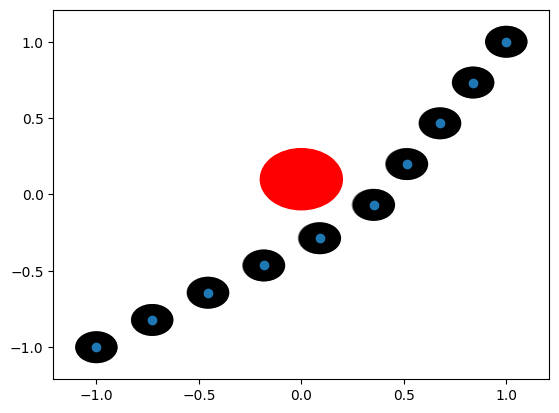

In [19]:
qs = to_mat(xs[i])
qs_prev = to_mat(xs[i-1])
fig, ax = plt.subplots()
robots = []
for q in qs_prev:
    circle = plt.Circle(q, r_robot, color='gray')
    robots.append(circle)
    ax.add_patch(circle)
for q in qs:
    circle = plt.Circle(q, r_robot, color='k')
    robots.append(circle)
    ax.add_patch(circle)

circle = plt.Circle(center_obs, r_obs, color='r')
ax.add_patch(circle)
ax = plt.scatter(*qs.T)
i += 1

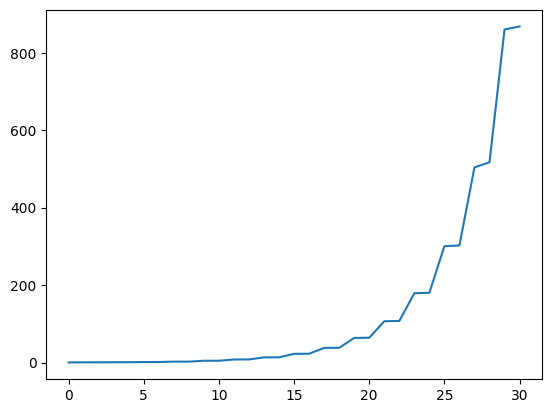

In [20]:
sigmas = jnp.array([h.sigma for h in solver.history])
plt.plot(sigmas)